<a href="https://colab.research.google.com/github/orlandxrf/curso-dl/blob/main/notebooks/11b_Deteccion_de_Outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de Outliers con Autoencoders

Para la detección de valores atípicos se aplica una técnica basada en aprendizaje profundo no supervisado para datos de texto.

Ejemplo tomado de [Github](https://github.com/avisheknag17/public_ml_models/blob/master/outlier_detection_in_movie_plots_ann/notebook/movie_plots_outlier_detector.ipynb)

## Conjunto de datos

El conjunto de datos usado es [Wikipedia Movie Plots](https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots).

El conjunto de datos contiene descripciones de 34.886 películas de todo el mundo.

In [ ]:
import os

URL = 'https://github.com/orlandxrf/curso-dl/blob/main/data/wiki_movie_plots_deduped.zip?raw=True'
data_folder = 'data'
filepath = os.path.join(data_folder, 'wiki_movie_plots_deduped.zip')

# crear carpeta para almacenar el conjunto de datos
! mkdir {data_folder}
# descargar conjunto de datos y alamcenar
! wget -nc {URL} -O {filepath}

--2022-04-26 03:05:07--  https://github.com/orlandxrf/curso-dl/blob/main/data/wiki_movie_plots_deduped.zip?raw=True
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/orlandxrf/curso-dl/raw/main/data/wiki_movie_plots_deduped.zip [following]
--2022-04-26 03:05:08--  https://github.com/orlandxrf/curso-dl/raw/main/data/wiki_movie_plots_deduped.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/orlandxrf/curso-dl/main/data/wiki_movie_plots_deduped.zip [following]
--2022-04-26 03:05:08--  https://raw.githubusercontent.com/orlandxrf/curso-dl/main/data/wiki_movie_plots_deduped.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuser

In [ ]:
import pandas as pd

df = pd.read_csv('data/wiki_movie_plots_deduped.zip', compression='zip', index_col=False, header=0)

df.head(10)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....


In [ ]:
print (f"\nLongitud del dataset: {len(df):,}")


Longitud del dataset: 34,886


Seleccionar solo la trama para la detección de outliers, y el título solo como identificador

In [ ]:
title_plot_df = df[['Title','Plot']]
title_plot_df.head(10)

,Title,Plot
0,Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr..."
1,Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov..."
2,The Martyred Presidents,"The film, just over a minute long, is composed..."
3,"Terrible Teddy, the Grizzly King",Lasting just 61 seconds and consisting of two ...
4,Jack and the Beanstalk,The earliest known adaptation of the classic f...
5,Alice in Wonderland,"Alice follows a large white rabbit down a ""Rab..."
6,The Great Train Robbery,The film opens with two bandits breaking into ...
7,The Suburbanite,The film is about a family who move to the sub...
8,The Little Train Robbery,The opening scene shows the interior of the ro...
9,The Night Before Christmas,Scenes are introduced using lines of the poem....


In [ ]:
# como luce una trama
title_plot_df.iloc[0,0] # título

'Kansas Saloon Smashers'

In [ ]:
title_plot_df.iloc[0,1] # trama

"A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man's bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man, pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register. The bartender then sprays seltzer water in Nation's face before a group of policemen appear and order everybody to leave.[1]"

### Limpiar el dataset

1.  Eliminación de etiquetas (como `<html>`, `<p>`)
2.  Eliminación de signos de puntuación (como ',','.','!', etc.)
3.  Eliminación de múltiples espacios en blanco entre textos
4.  Eliminación de números
5.  Eliminación de palabras vacías (como 'at', 'to', 'the', 'and', etc.)
6.  Eliminación de palabras muy cortas
7.  Stemming, es decir, convertir palabras a su forma raíz (como para 'playing', 'played' solo habrá un token después del procesamiento: 'play', que es la palabra raíz)

In [ ]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

Como se vera el texto (trama) después de la limpieza

In [ ]:
clean_text(title_plot_df.iloc[0,1])

'bartend work saloon serv drink custom fill stereotyp irish man bucket beer carri nation follow burst insid assault irish man pull hat ey dump beer head group begin wreck bar smash fixtur mirror break cash regist bartend sprai seltzer water nation face group policemen appear order everybodi leav'

Aunque el texto que se acaba de limpiar ya no es gramaticalmente correcto, aún mantiene el contexto que es esencial para el procesamiento posterior.

In [ ]:
# limpiar todo el conjunto de tramas
title_plot_df['Plot'] = title_plot_df['Plot'].map(lambda x: clean_text(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Análisis exploratorio de datos (EDA: Exploratory Data Analysis)

Para la exploración de datos, buscar las 50 palabras/tokens más frecuentes presentes en las tramas.

In [ ]:
from collections import Counter
from tqdm.notebook import tqdm

aggregate_counter = Counter()
for row_index,row in tqdm(title_plot_df.iterrows(), total=len(title_plot_df)):
    c = Counter(row['Plot'].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(50)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

  0%|          | 0/34886 [00:00<?, ?it/s]

In [ ]:
# definir función para graficar las palabras encontradas
import matplotlib.pyplot as plt
import seaborn as sns

def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

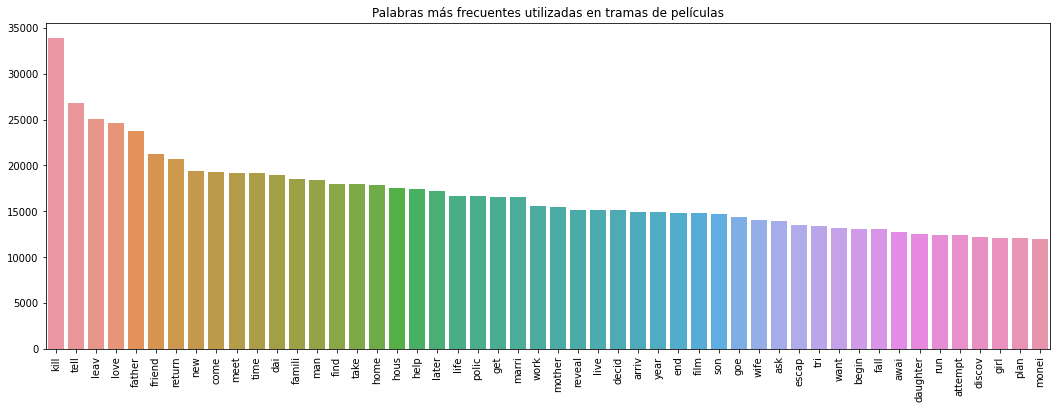

In [ ]:
# graficar las palabras
barplot(words=common_words, words_counts=common_words_counts, title='Palabras más frecuentes utilizadas en tramas de películas')

Ahora, hacer lo contrario, buscar las 50 palabras/tokens menos frecuentes en todas las películas y graficar.

In [ ]:
from itertools import islice

def key_word_counter(tupple):
    return tupple[1]

all_word_counts = sorted(aggregate_counter.items(), key=key_word_counter)
uncommon_words = [word[0] for word in islice(all_word_counts, 50)]
uncommon_word_counts = [word[1] for word in islice(all_word_counts, 50)] 

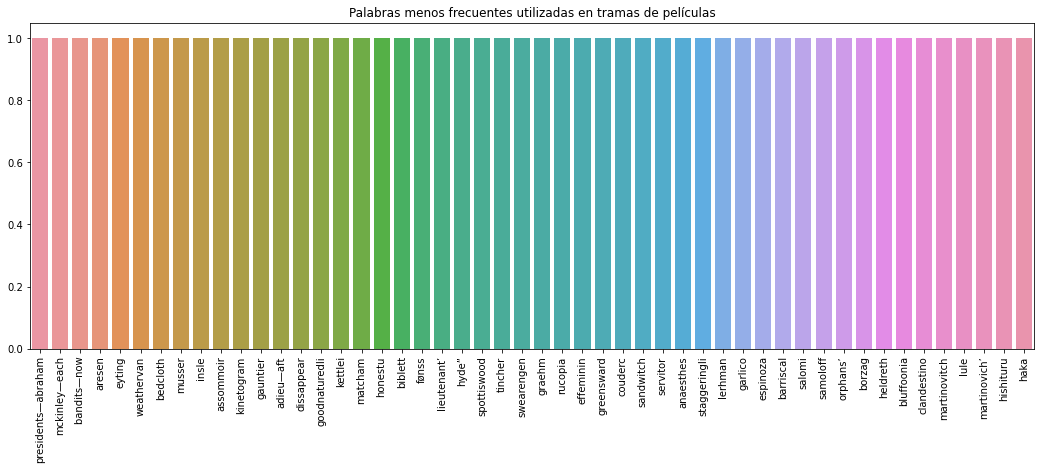

In [ ]:
barplot(words=uncommon_words, words_counts=uncommon_word_counts, title='Palabras menos frecuentes utilizadas en tramas de películas')

A partir de este análisis intuitivo, se puede concluir que "Las películas más singulares" definitivamente no contendrán las palabras más frecuentes y pueden contener palabras menos frecuentes.

Esta es una vista de muy alto nivel. En la práctica, se necesita ver el significado contextual de la trama de la película y descubrir los elementos más raros.

### Preparar el conjunto de datos

**Doc2Vec** y **Word2Vec** son las mejores opciones para preprar el conjunto de datos.

**Doc2Vec** muestra aleatoriamente palabras de textos y entrena internamente un modelo de red neuronal que proporciona una representación vectorial numérica del texto. En este caso, como las tramas de las películas son textos bien escritos, se usará **Doc2Vec** como *Modelo espacial vectorial*.

In [ ]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['Plot']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['Plot']).split())
                                     for index, row in df_x.iterrows()]))

In [ ]:
# entrenar para obtener los Doc2Vec

doc2vec_tr = Doc2VecTransformer(vector_size=300)
doc2vec_tr.fit(title_plot_df)
doc2vec_vectors = doc2vec_tr.transform(title_plot_df)

100%|██████████| 34886/34886 [00:00<00:00, 1794773.38it/s]


In [ ]:
# visualizar los vectores obtenidos
print(doc2vec_vectors)

[[ 0.00079741 -0.00058917  0.00065152 ...  0.00071149 -0.00013082
   0.00040986]
 [-0.00153682  0.00128344 -0.0016194  ... -0.00154627 -0.00111825
  -0.00037769]
 [ 0.00077619 -0.00033679  0.00161591 ...  0.00151999 -0.00149462
   0.00098432]
 ...
 [-0.00094477 -0.0013401   0.00148453 ...  0.00156366 -0.00133874
   0.00135214]
 [-0.00136248  0.00062739  0.00099778 ...  0.00089709  0.00094071
   0.00093528]
 [-0.00111602  0.0009114   0.00092655 ...  0.00087284  0.00093817
   0.00102314]]


## Entrenamiento de una red neuronal Autoencoder

El problema para la detección de outliers **no está supervisado** en absoluto y no se tienen datos etiquetados (como valores atípicos/no atípicos).

Entonces, se utilizará una red neuronal **AutoEncoder** de 5 capas de profundidad para entrenar el modelo.

El Autoencoder es un tipo especial de red neuronal que copia datos de entrada a datos de salida. Este proceso se conoce como *'reconstrucción'*. 

Las *capas ocultas* de la red hacen el trabajo de extracción y decodificación de características. Al final de todo el proceso, se genera alguna pérdida y el punto de datos que es diferente de los demás incurre en más pérdidas.

![Forward](https://drive.google.com/uc?id=1g6E9AoRLvEBUsh9BkV1PdPv_cRKl7nsG)



In [ ]:
from sklearn.neural_network import MLPRegressor

auto_encoder = MLPRegressor(hidden_layer_sizes=(600, 150, 600,))
auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)
predicted_vectors = auto_encoder.predict(doc2vec_vectors)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [ ]:
print(predicted_vectors)

[[ 0.00039871 -0.00224962 -0.00136091 ... -0.00122246  0.00151759
   0.00186148]
 [ 0.0008782  -0.00183349 -0.00153809 ... -0.00151113  0.00136701
   0.00188405]
 [ 0.00133096 -0.00225801 -0.00133984 ... -0.00091039  0.00152568
   0.00152359]
 ...
 [ 0.00080944 -0.00188964 -0.00129464 ... -0.00148985  0.00126841
   0.00208616]
 [ 0.00092024 -0.00167977 -0.00147656 ... -0.00141748  0.00125867
   0.0020006 ]
 [ 0.00093425 -0.00169442 -0.00147201 ... -0.00123532  0.0011124
   0.00163038]]


El AutoEncoder en realidad no es más que un regresor no lineal profundo.

También se puede observar su precisión.

In [ ]:
auto_encoder.score(predicted_vectors, doc2vec_vectors)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


0.8477725333365314

Esto significa que el 84% de la información de las variables de entrada se reconstruye con éxito.

También se puede observar la función de pérdida de toda la red.

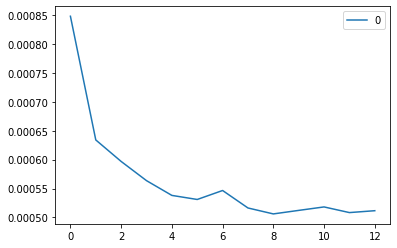

In [ ]:
pd.DataFrame(auto_encoder.loss_curve_).plot()

### Medir la similitud de la salida con la real

Una vez obtenidos los vectores de salida, se puede medir la pérdida.

La 'pérdida' (loss) está idealmente dada por la expresión de 'factor atípico' (Outlier Factor).
<br><br>
$[OF]^{i} = \frac{1}{d} \sum^{d}_{k=1} (x^{k} - o^{k})^{2}$
<br><br>

Donde:<br>
<br>

$[OF]^{i} = \text{factor atípico para la } i^{th} \text{instancia de datos}$<br>

$d = \text{número total de características (en nuestro caso, } d=300\text{)}$<br>

$x^{k} = k^{th} \text{valor característico de la entrada } (1 ≤ k ≤ d)$<br>

$o^{k} = k^{th} \text{valor de característico de salida (en realidad es la entrada reconstruida)}$<br><br>

> **Los valores atípicos siempre tendrán una tendencia a no seguir el patrón y darán un mayor error de reconstrucción**. Asi que, **un valor más alto de [OF] denota un posible "valor atípico".**

Para realizar la similitud se aplicará la [similitud coseno](https://en.wikipedia.org/wiki/Cosine_similarity) como medida.

Ahora $[OF]^{i}$ se convierte en una simple medida de coseno del vector de entrada y salida del $i^{th}$ punto de datos.

> **Pero una diferencia aquí**: el valor más bajo de $[OF]^{i}$ indica un posible valor atípico en lugar de un valor más alto.

Los pasos para hacer esto son:

1.   Calcular la "similitud coseno" entre el vector de entrada y el vector de salida del $i^{th}$ punto de datos.
2.   Ordenar todos los valores de similitud coseno en orden creciente.
3.   Seleccionar los valores 'k' superiores ('k' es la entrada proporcionada por el usuario) y los posibles valores atípicos serán los puntos de datos correspondientes.



In [ ]:
from scipy.spatial.distance import cosine

def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(title_plot_df)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=5):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print(f'Título de la Película:\t{title_plot_df.iloc[index, 0]}')  
        print(f'Similitud Coseno:\t{consine_sim_val}')
        print('-'*100)

In [ ]:
# llamar las funciones anteriores para obtener los principales valores atípicos 'k'
k = 5
print(f'Top {k} películas únicas\n')

sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors, predicted_vectors=predicted_vectors)
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities, n=k)

Top 5 películas únicas

Título de la Película:	Anatomy of a Murder
Similitud Coseno:	-0.2110362946987152
----------------------------------------------------------------------------------------------------
Título de la Película:	 O
Similitud Coseno:	-0.2104514241218567
----------------------------------------------------------------------------------------------------
Título de la Película:	Thirunaal
Similitud Coseno:	-0.19554367661476135
----------------------------------------------------------------------------------------------------
Título de la Película:	Life Mein Kabhie Kabhiee
Similitud Coseno:	-0.1820448338985443
----------------------------------------------------------------------------------------------------
Título de la Película:	Love
Similitud Coseno:	-0.18143142759799957
----------------------------------------------------------------------------------------------------


### Validación de resultados

Para los problemas de "detección de valores atípicos" no supervisados ​​en Machine Learning, validar la salida es realmente un desafío porque no se tienen datos etiquetados como punto de referencia.

Además, como se esta usando 'Doc2Vec', verificar la validez contextual es difícil.

Por lo tanto, se adoptará un enfoque más simple y se validarán los resultados con las observaciones de la "etapa de exploración de datos" (EDA).

Comprobar si hay una intersección entre *todas las palabras procesadas de la película más singular* y *palabras muy frecuentes en todas las películas*.

In [ ]:
common_word_counter = Counter(aggregate_counter.most_common(1000))


most_unique_movie_index, cosine_sim_val = sorted_cosine_similarities[0]
most_unique_movie_plot = title_plot_df.iloc[most_unique_movie_index, 1]
most_unique_movie_words_counter = Counter(preprocess_string(most_unique_movie_plot))
intersected_common_word_counter = common_word_counter & most_unique_movie_words_counter
intersected_common_words = [word[0] for word in intersected_common_word_counter.items()]
intersected_common_word_counts = [word[1] for word in intersected_common_word_counter.items()]
intersected_common_word_counter

Counter()

Entonces, no hay intersección.

Lo que significa que **la trama de la película más singular no contiene palabras muy frecuentes que son muy comunes para otras tramas de películas**. 

Esto es bastante relevante para una película **única** que es diferente a otras. Entonces, la solución funciona perfectamente

Ahora, veamos el escenario opuesto: **Si la película más singular contiene las palabras menos frecuentes del corpus o no**.

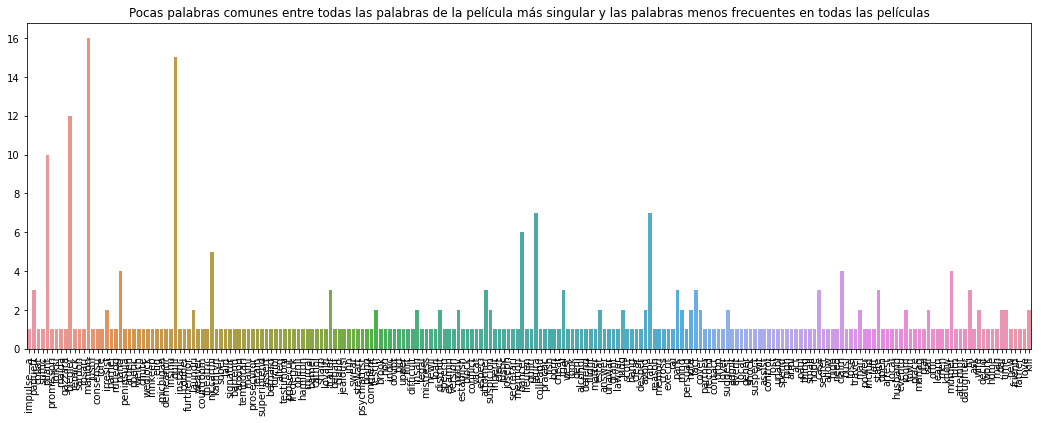

In [ ]:
uncommon_word_count_items = [word for word in islice(all_word_counts, 300000)]
all_movies_uncommon_word_counter = Counter(dict(uncommon_word_count_items))

intersected_uncommon_word_counter = all_movies_uncommon_word_counter & most_unique_movie_words_counter
intersected_uncommon_words = [word[0] for word in intersected_uncommon_word_counter.items()]
intersected_uncommon_word_counts = [word[1] for word in intersected_uncommon_word_counter.items()]
barplot(words=intersected_uncommon_words, words_counts=intersected_uncommon_word_counts,
        title='Pocas palabras comunes entre todas las palabras de la película más singular y las palabras menos frecuentes en todas las películas')

Lo que se observa de la Fgura, se puede decir que: **La trama de la película más singular contiene muchas palabras menos frecuentes que son muy poco comunes en otras tramas de películas.**